# Neural Network Models for Speaker Classification

Last Update: 12/01/2019 by Chen Liang

This notebook includes the following deep learning models: 1) CNN on MFCC 2) CNN on Chroma

In [14]:
import librosa
import numpy as np
import shutil
import os
import re
from joblib import Parallel, delayed
import multiprocessing 
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from scipy import stats
import sklearn.metrics as metrices
import seaborn as sns
import librosa.display

In [3]:
raw_dir='recordings/selected_recordings/'
silence_removed_dir='recordings/silence_removed/'
unified_dir='recordings/unified/'

## Preparation: Data Understanding

For this dataset, each speaker is required to read the following paragraph:
>*Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.*

To understand the potential pronounciation patterns, this paragraph is firstly converted to a list of phonemes:

In [3]:
with open('tools/CMUDict/cmudict.dict','r') as f:
    word_phoneme=f.readlines()
reading_paragraph='Please call Stella. Ask her to bring these things with her from the store: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags, and we will go meet her Wednesday at the train station'
reading_words=reading_paragraph.split()

In [4]:
word_dict={}
for i in word_phoneme:
    word=i[:i.index(' ')]
    phoneme=i[i.index(' ')+1:].strip('\n')
    word_dict[word]=phoneme

In [5]:
words_not_found=[]
phonemes={}
for i in reading_words:
    i=re.sub(r'[^\w]','', i)
    if i.lower() in word_dict:
        phonemes[i]=word_dict[i.lower()]
    else:
        words_not_found.append(i)

In [6]:
words_not_found

[]

In [7]:
reading_phonemes=[]
for item in phonemes:
    reading_phonemes.append(phonemes[item])
reading_phonemes_string=' '.join(reading_phonemes)

In [8]:
print(reading_phonemes_string)
print('\nNumber of Phonemes: ',len(reading_phonemes_string.split(' ')))

P L IY1 Z K AO1 L S T EH1 L AH0 AE1 S K HH ER1 T UW1 B R IH1 NG DH IY1 Z TH IH1 NG Z W IH1 DH F R AH1 M DH AH0 S T AO1 R S IH1 K S S P UW1 N Z AH1 V F R EH1 SH S N OW1 P IY1 Z F AY1 V TH IH1 K S L AE1 B Z B L UW1 CH IY1 Z AH0 N D M EY1 B IY0 AH0 S N AE1 K F AO1 R B R AH1 DH ER0 B AA1 B W IY1 AO1 L S OW0 N IY1 D S M AO1 L P L AE1 S T IH0 K S N EY1 K B IH1 G T OY1 F R AA1 G K IH1 D Z SH IY1 K AE1 N S K UW1 P IH1 N T UW0 TH R IY1 R EH1 D B AE1 G Z W IY1 W IH1 L G OW1 M IY1 T W EH1 N Z D IY0 AE1 T T R EY1 N S T EY1 SH AH0 N

Number of Phonemes:  192


In [9]:
phoneme_lengths=[]
for i in phonemes:
    phoneme_lengths.append(len(phonemes[i].split(' ')))

In [10]:
pl=np.array(phoneme_lengths)
print('Mean of Phonemes per Word: ', np.mean(pl))
print('Mode of Phonemes per Word: ', stats.mode(pl)[0][0])

Mean of Phonemes per Word:  3.4285714285714284
Mode of Phonemes per Word:  3


These information will be taken into consideration while designing the structure of CNN models.

## Convolutional Neural Network on MFCC

Key idea: Use filters to extract key features from a series of adjacent MFCC slices

### Extract MFCC

In [11]:
mfcc_window_size=0.025
mfcc_stride_size=0.01
mfcc_num_of_features=14

In [12]:
def extract_mfcc(fname):
    y,sr=librosa.load(unified_dir+fname)
    result=librosa.feature.mfcc(y=y,n_mfcc=mfcc_num_of_features,hop_length=int(mfcc_window_size*sr), n_fft=int(mfcc_stride_size*sr))
    result=librosa.util.normalize(result)
    #Add label as well
    if 'mandarin' in fname:
        label=0
    elif 'english' in fname:
        label=1
    elif 'spanish' in fname:
        label=2
    else:
        label=-1
    return [result,label]

In [13]:
result=Parallel(n_jobs=12)(delayed(extract_mfcc)(fname) for fname in os.listdir(unified_dir))

In [14]:
X=[]
y=[]
for i in result:
    X.append(i[0])
    y.append(i[1])

In [16]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)

In [17]:
def change_input_format(X):
    Xc=np.stack(X,axis=0)
#     Xc=np.swapaxes(Xc,0,1)
#     Xc=np.swapaxes(Xc,1,2)
    return Xc

In [18]:
X_train=change_input_format(X_train)
X_test=change_input_format(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [19]:
X_test.shape

(60, 14, 800, 1)

In [20]:
y_train.shape

(540,)

### Set up CNN Model

Directly fit on extracted MFCC features. Input shape is (14,800,1) per sample

In [15]:
#input_shape=X_all[:,:,0].shape
input_shape=(14,800,1)
print(input_shape)

(14, 800, 1)


In [25]:
def create_model():
    model1=models.Sequential()
    model1.add(layers.Conv2D(32,kernel_size=(5,9),strides=(1,3),activation='relu',input_shape=input_shape))
    model1.add(layers.MaxPooling2D((2, 4)))
    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D((2, 2)))
    model1.add(layers.Dropout(0.50))
    model1.add(layers.Flatten())
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(3, activation='softmax'))
    return model1

In [26]:
model=create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=75, 
                    validation_data=(X_test, y_test))

Train on 540 samples, validate on 60 samples
Epoch 1/75
540/540 [==============================] - 1s 1ms/sample - loss: 0.9375 - accuracy: 0.6148 - val_loss: 0.8681 - val_accuracy: 0.6333
Epoch 2/75
540/540 [==============================] - 0s 224us/sample - loss: 0.8998 - accuracy: 0.6204 - val_loss: 0.8786 - val_accuracy: 0.6333
Epoch 3/75
540/540 [==============================] - 0s 229us/sample - loss: 0.8938 - accuracy: 0.6204 - val_loss: 0.8459 - val_accuracy: 0.6333
Epoch 4/75
540/540 [==============================] - 0s 220us/sample - loss: 0.8572 - accuracy: 0.6204 - val_loss: 0.8224 - val_accuracy: 0.6333
Epoch 5/75
540/540 [==============================] - 0s 212us/sample - loss: 0.8510 - accuracy: 0.6222 - val_loss: 0.7761 - val_accuracy: 0.6333
Epoch 6/75
540/540 [==============================] - 0s 216us/sample - loss: 0.8261 - accuracy: 0.6259 - val_loss: 0.7706 - val_accuracy: 0.6333
Epoch 7/75
540/540 [==============================] - 0s 218us/sample - loss: 0.7

540/540 [==============================] - 0s 216us/sample - loss: 0.0538 - accuracy: 0.9870 - val_loss: 0.4487 - val_accuracy: 0.8500
Epoch 57/75
540/540 [==============================] - 0s 211us/sample - loss: 0.0419 - accuracy: 0.9889 - val_loss: 0.4618 - val_accuracy: 0.8500
Epoch 58/75
540/540 [==============================] - 0s 209us/sample - loss: 0.0694 - accuracy: 0.9667 - val_loss: 0.4673 - val_accuracy: 0.8500
Epoch 59/75
540/540 [==============================] - 0s 211us/sample - loss: 0.0636 - accuracy: 0.9870 - val_loss: 0.3858 - val_accuracy: 0.8333
Epoch 60/75
540/540 [==============================] - 0s 214us/sample - loss: 0.0413 - accuracy: 0.9926 - val_loss: 0.3740 - val_accuracy: 0.8667
Epoch 61/75
540/540 [==============================] - 0s 246us/sample - loss: 0.0545 - accuracy: 0.9796 - val_loss: 0.3874 - val_accuracy: 0.8833
Epoch 62/75
540/540 [==============================] - 0s 227us/sample - loss: 0.0767 - accuracy: 0.9685 - val_loss: 0.4174 - val_

### Evaluation

In [27]:
y_pred=tf.argmax(model.predict(X_test),1)

In [28]:
y_pred

<tf.Tensor: id=17865, shape=(60,), dtype=int64, numpy=
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)>

In [29]:
print('Test Accuracy: ',metrices.accuracy_score(y_test,y_pred))
print('F1 Score: ',metrices.f1_score(y_test,y_pred,average='macro'))
confusion_matrix=metrices.confusion_matrix(y_test,y_pred)

Test Accuracy:  0.9166666666666666
F1 Score:  0.8638324704632948


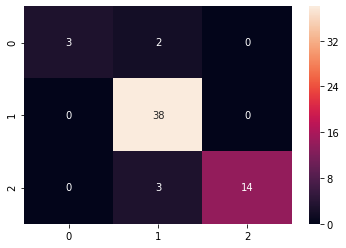

<Figure size 7200x504 with 0 Axes>

In [30]:
#Note: Matplotlib3.1.1 will cause problem displaying the plot
cm_plot=sns.heatmap(confusion_matrix, annot=True)
plt.figure(figsize = (100,7))
fig = cm_plot.get_figure()
fig.savefig('nn_cm.png') 

## Convolutional Neural Network on Chroma

### Extract Chroma

In [12]:
def get_chroma(fname):
    y,sr=librosa.load(unified_dir+fname)
    result=librosa.feature.chroma_stft(y=y, sr=sr)
    #Add label as well
    if 'mandarin' in fname:
        label=0
    elif 'english' in fname:
        label=1
    elif 'spanish' in fname:
        label=2
    else:
        label=-1
    return [result,label,fname]

In [13]:
result=Parallel(n_jobs=12)(delayed(get_chroma)(fname) for fname in os.listdir(unified_dir))

In [65]:
files_selected=['mandarin8.mp3.wav','english15.mp3.wav','spanish161.mp3.wav']
chromes_selected=[]
for i in files_selected:
    for j in result:
        if j[2]==i:
            chromes_selected.append(j[0])

In [79]:
def plot_and_save_chrome(chrome,fname):
    fig=plt.figure(figsize=(16, 4))
    librosa.display.specshow(chrome, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(fname+'Chromagram')
    plt.tight_layout()
    plt.show()
    fig.savefig('ch_'+fname+'.png',dpi=400)

In [80]:
selected_part=int(861/10)

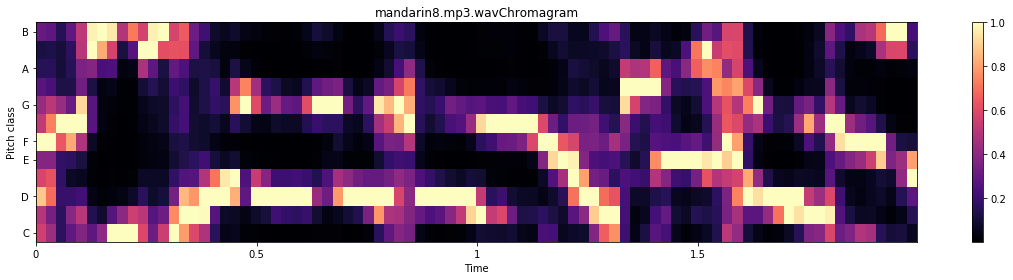

In [81]:
plot_and_save_chrome(chromes_selected[0][:,:selected_part],files_selected[0])

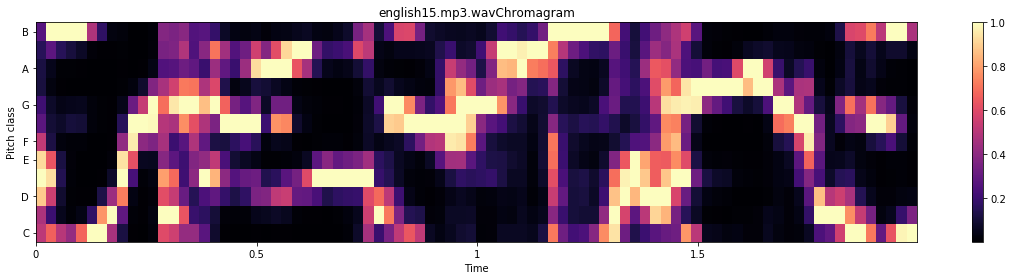

In [82]:
plot_and_save_chrome(chromes_selected[1][:,:selected_part],files_selected[1])

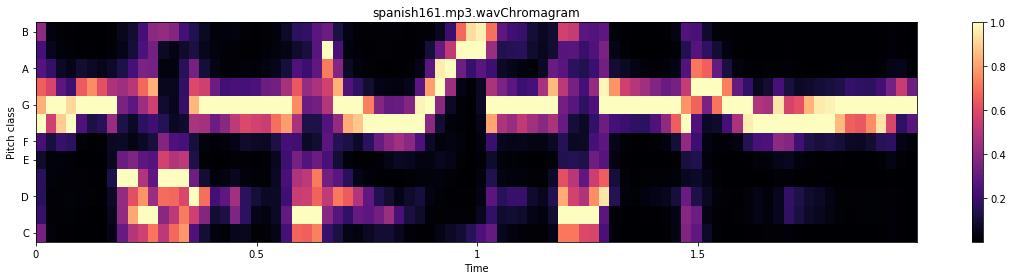

In [83]:
plot_and_save_chrome(chromes_selected[2][:,:selected_part],files_selected[2])

In [219]:
X=[]
y=[]
for i in result:
    X.append(i[0])
    y.append(i[1])

In [220]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)

In [221]:
def change_input_format(X):
    Xc=np.stack(X,axis=0)
#     Xc=np.swapaxes(Xc,0,1)
#     Xc=np.swapaxes(Xc,1,2)
    return Xc

In [222]:
X_train=change_input_format(X_train)
X_test=change_input_format(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [223]:
X_test.shape

(60, 12, 861, 1)

### Model1: Directly Apply CNN on Chroma

In [224]:
input_shape=(12,861,1)

In [225]:
def create_model():
    model1=models.Sequential()
    model1.add(layers.Conv2D(32,kernel_size=(12,9),strides=(1,3),activation='relu',input_shape=input_shape))
    model1.add(layers.MaxPooling2D((1, 4)))
    model1.add(layers.Conv2D(64, (1, 3), activation='relu'))
    model1.add(layers.MaxPooling2D((1, 2)))
    model1.add(layers.Flatten())
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(3, activation='softmax'))
    return model1

In [226]:
model=create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=75, 
                    validation_data=(X_test, y_test))

Train on 540 samples, validate on 60 samples
Epoch 1/75
540/540 [==============================] - 1s 2ms/sample - loss: 0.9283 - accuracy: 0.5981 - val_loss: 0.7811 - val_accuracy: 0.6833
Epoch 2/75
540/540 [==============================] - 0s 766us/sample - loss: 0.8939 - accuracy: 0.6148 - val_loss: 0.7922 - val_accuracy: 0.6833
Epoch 3/75
540/540 [==============================] - 0s 771us/sample - loss: 0.8691 - accuracy: 0.6148 - val_loss: 0.7845 - val_accuracy: 0.6833
Epoch 4/75
540/540 [==============================] - 0s 818us/sample - loss: 0.8417 - accuracy: 0.6148 - val_loss: 0.8396 - val_accuracy: 0.7167
Epoch 5/75
540/540 [==============================] - 0s 774us/sample - loss: 0.8306 - accuracy: 0.6315 - val_loss: 0.7450 - val_accuracy: 0.6833
Epoch 6/75
540/540 [==============================] - 0s 772us/sample - loss: 0.7693 - accuracy: 0.6685 - val_loss: 0.6981 - val_accuracy: 0.7000
Epoch 7/75
540/540 [==============================] - 0s 802us/sample - loss: 0.6

540/540 [==============================] - 0s 766us/sample - loss: 5.7950e-04 - accuracy: 1.0000 - val_loss: 1.2525 - val_accuracy: 0.7167
Epoch 57/75
540/540 [==============================] - 0s 766us/sample - loss: 5.5393e-04 - accuracy: 1.0000 - val_loss: 1.2665 - val_accuracy: 0.7333
Epoch 58/75
540/540 [==============================] - 0s 770us/sample - loss: 5.2850e-04 - accuracy: 1.0000 - val_loss: 1.2582 - val_accuracy: 0.7167
Epoch 59/75
540/540 [==============================] - 0s 771us/sample - loss: 5.0977e-04 - accuracy: 1.0000 - val_loss: 1.2671 - val_accuracy: 0.7167
Epoch 60/75
540/540 [==============================] - 0s 765us/sample - loss: 4.9079e-04 - accuracy: 1.0000 - val_loss: 1.2748 - val_accuracy: 0.7333
Epoch 61/75
540/540 [==============================] - 0s 768us/sample - loss: 4.7411e-04 - accuracy: 1.0000 - val_loss: 1.2811 - val_accuracy: 0.7333
Epoch 62/75
540/540 [==============================] - 0s 772us/sample - loss: 4.5338e-04 - accuracy: 1.00

### Evaluation

In [227]:
y_pred=tf.argmax(model.predict(X_test),1)

In [228]:
y_pred

<tf.Tensor: id=170622, shape=(60,), dtype=int64, numpy=
array([1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2], dtype=int64)>

In [229]:
print('Test Accuracy: ',metrices.accuracy_score(y_test,y_pred))
print('F1 Score: ',metrices.f1_score(y_test,y_pred,average='macro'))
confusion_matrix=metrices.confusion_matrix(y_test,y_pred)

Test Accuracy:  0.7166666666666667
F1 Score:  0.5268509937184637


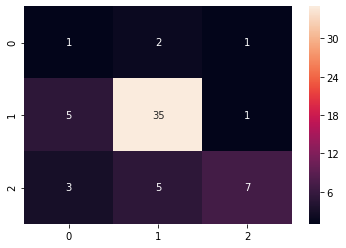

<Figure size 7200x504 with 0 Axes>

In [230]:
#Note: Matplotlib3.1.1 will cause problem displaying the plot
cm_plot=sns.heatmap(confusion_matrix, annot=True)
plt.figure(figsize = (100,7))
fig = cm_plot.get_figure()
fig.savefig('nn_cm.png') 

### Model2: Keep Max Values Only

In [250]:
result2=[]
for item in result:
    ch,label,fname=item
    new_result=[]
    for i in range(ch.shape[1]):
        new_result.append(float(np.argmax(ch[:,i])))
    result2.append([np.array(new_result),label])

In [251]:
X=[]
y=[]
for i in result2:
    X.append(i[0])
    y.append(i[1])

In [252]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
X_train=np.expand_dims(X_train,axis=1)
X_test=np.expand_dims(X_test,axis=1)
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)

In [253]:
def change_input_format(X):
    Xc=np.stack(X,axis=0)
#     Xc=np.swapaxes(Xc,0,1)
#     Xc=np.swapaxes(Xc,1,2)
    return Xc

In [254]:
X_train=change_input_format(X_train)
X_test=change_input_format(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [255]:
X_test.shape

(60, 1, 861, 1)

In [256]:
input_shape=(1,861,1)

In [257]:
def create_model():
    model1=models.Sequential()
    model1.add(layers.Conv2D(64,kernel_size=(1,9),strides=(1, 3),activation='relu',input_shape=input_shape))
    model1.add(layers.AveragePooling2D((1, 5)))
    model1.add(layers.Flatten())
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(3, activation='softmax'))
    return model1

In [258]:
model=create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=75, 
                    validation_data=(X_test, y_test))

Train on 540 samples, validate on 60 samples
Epoch 1/75
540/540 [==============================] - 1s 1ms/sample - loss: 1.2782 - accuracy: 0.5685 - val_loss: 0.9312 - val_accuracy: 0.6167
Epoch 2/75
540/540 [==============================] - 0s 312us/sample - loss: 0.9099 - accuracy: 0.5722 - val_loss: 0.9396 - val_accuracy: 0.6167
Epoch 3/75
540/540 [==============================] - 0s 292us/sample - loss: 0.8706 - accuracy: 0.6296 - val_loss: 0.9185 - val_accuracy: 0.6167
Epoch 4/75
540/540 [==============================] - 0s 275us/sample - loss: 0.8421 - accuracy: 0.6222 - val_loss: 0.9305 - val_accuracy: 0.6167
Epoch 5/75
540/540 [==============================] - 0s 268us/sample - loss: 0.8119 - accuracy: 0.6370 - val_loss: 0.9699 - val_accuracy: 0.6000
Epoch 6/75
540/540 [==============================] - 0s 277us/sample - loss: 0.7527 - accuracy: 0.6519 - val_loss: 0.9118 - val_accuracy: 0.5667
Epoch 7/75
540/540 [==============================] - 0s 262us/sample - loss: 0.7

540/540 [==============================] - 0s 279us/sample - loss: 0.0083 - accuracy: 1.0000 - val_loss: 2.3309 - val_accuracy: 0.5833
Epoch 57/75
540/540 [==============================] - 0s 273us/sample - loss: 0.0083 - accuracy: 1.0000 - val_loss: 2.3750 - val_accuracy: 0.5833
Epoch 58/75
540/540 [==============================] - 0s 270us/sample - loss: 0.0077 - accuracy: 1.0000 - val_loss: 2.3805 - val_accuracy: 0.5833
Epoch 59/75
540/540 [==============================] - 0s 266us/sample - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.4361 - val_accuracy: 0.6000
Epoch 60/75
540/540 [==============================] - 0s 257us/sample - loss: 0.0069 - accuracy: 1.0000 - val_loss: 2.4321 - val_accuracy: 0.6000
Epoch 61/75
540/540 [==============================] - 0s 257us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2.4294 - val_accuracy: 0.5833
Epoch 62/75
540/540 [==============================] - 0s 259us/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 2.4535 - val_

This one does not seem to work. 